<a href="https://colab.research.google.com/github/samharsh02/Text-generation-using-LSTM/blob/main/TEXT_GENERATION_USING_LSTM_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

first, import all the needed libraries for our project:

In [ ]:
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
import matplotlib

from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed
from keras.callbacks import ModelCheckpoint
import keras.utils as ku
#from keras import to_categorical
#import tensorflow.keras.utils.np_utils as np_utils


**Load the dataset :**

kindly load the dataset into your machine before executing the code


In [ ]:
dataset = pd.read_csv('taylor_swift_lyrics.csv', encoding = "latin1")


In [ ]:
dataset.head()

,artist,album,track_title,track_n,lyric,line,year
0,Taylor Swift,Taylor Swift,Tim McGraw,1,He said the way my blue eyes shined,1,2006
1,Taylor Swift,Taylor Swift,Tim McGraw,1,Put those Georgia stars to shame that night,2,2006
2,Taylor Swift,Taylor Swift,Tim McGraw,1,"I said, ""That's a lie""",3,2006
3,Taylor Swift,Taylor Swift,Tim McGraw,1,Just a boy in a Chevy truck,4,2006
4,Taylor Swift,Taylor Swift,Tim McGraw,1,That had a tendency of gettin' stuck,5,2006


In [ ]:
dataset.describe()

,track_n,line,year
count,4862.000000,4862.000000,4862.000000
mean,8.216989,28.426573,2011.882764
std,4.696379,18.343649,3.571447
min,1.000000,1.000000,2006.000000
25%,4.000000,13.000000,2010.000000
50%,8.000000,26.000000,2012.000000
75%,12.000000,41.000000,2014.000000
max,19.000000,101.000000,2017.000000


We need to concatenate the lines of each song to get each song by its own in one string.

In [ ]:
def processFirstLine(lyrics, songID, songName, row):
    lyrics.append(row['lyric'] + '\n')
    songID.append( row['year']*100+ row['track_n'])
    songName.append(row['track_title'])
    return lyrics,songID,songName

In [ ]:
lyrics = []
songID = []
songName = []

# songNumber indicates the song number in the dataset
songNumber = 1

i = 0
isFirstLine = True

# Iterate through every lyrics line and join them together for each song independently
for index,row in dataset.iterrows():
    if(songNumber == row['track_n']):
        if (isFirstLine):
            lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
            isFirstLine = False
        else :
            #if we are still in the same song , keep joining the lyrics
            lyrics[i] +=  row['lyric'] + '\n'
    #When it's done joining a song's lyrics lines , go to the next song :
    else :
        lyrics,songID,songName = processFirstLine(lyrics,songID,songName,row)
        songNumber = row['track_n']
        i+=1


In [ ]:

# Define a new pandas DataFrame to save songID , songName , Lyrics in it to use them later
lyrics_data = pd.DataFrame({'songID':songID, 'songName':songName, 'lyrics':lyrics })


After getting the wanted data from the dataset , we need to preprocess it.

## Preprocessing The Lyrics




In [ ]:
lyricsText =''
for listitem in lyrics:
    lyricsText += listitem


### 1- Convert the lyrics to lowercase :


In [ ]:
# Load the dataset and convert it to lowercase :
raw_text = lyricsText
raw_text = raw_text.lower()


### 2- Mapping characters :
 Make two dictionaries , one to convert chars to ints , the other to convert ints back to chars :


In [ ]:
# Mapping chars to ints :
chars = sorted(list(set(raw_text)))
int_chars = dict((i, c) for i, c in enumerate(chars))
chars_int = dict((i, c) for c, i in enumerate(chars))


In [ ]:
# Get number of chars and vocab in our text :
n_chars = len(raw_text)
n_vocab = len(chars)


In [ ]:
print('Total Characters : ' , n_chars) # number of all the characters in lyricsText.txt
print('Total Vocab : ', n_vocab) # number of unique characters


Total Characters :  173604
Total Vocab :  58


### 3- Make samples and labels :
Make samples and labels to feed the LSTM RNN

In [ ]:
# process the dataset:
seq_len = 100
data_X = []
data_y = []

for i in range(0, n_chars - seq_len, 1):
    # Input Sequeance(will be used as samples)
    seq_in  = raw_text[i:i+seq_len]
    # Output sequence (will be used as target)
    seq_out = raw_text[i + seq_len]
    # Store samples in data_X
    data_X.append([chars_int[char] for char in seq_in])
    # Store targets in data_y
    data_y.append(chars_int[seq_out])
n_patterns = len(data_X)
print( 'Total Patterns : ', n_patterns)


Total Patterns :  173504


### 4- Prepare the samples and labels :
prepare the samples and labels to be ready to go into our model.
* Reshape the samples
* Normalize them
* One hot encode the output targets

In [ ]:
# Reshape X to be suitable to go into LSTM RNN :
X = np.reshape(data_X , (n_patterns, seq_len, 1))
# Normalizing input data :
X = X/ float(n_vocab)
# One hot encode the output targets :
y = ku.to_categorical(data_y)

After we finished processing the dataset , we will start building our LSTM RNN model .

## Building The Model

## First way : From Scratch

We will start by determining how many layers our model will has , and how many nodes each layer will has :

In [ ]:
LSTM_layer_num = 4 # number of LSTM layers
layer_size = [256,256,256,256] # number of nodes in each layer

Define a sequential model :


In [ ]:
model = Sequential()

### LSTM layer

Add an input layer :

In [ ]:
model.add(LSTM(layer_size[0], input_shape =(X.shape[1], X.shape[2]), return_sequences = True))
model.add(Dropout(0.1))

Add some hidden layers :

In [ ]:
for i in range(1,LSTM_layer_num) :
    model.add(LSTM(layer_size[i], return_sequences=True))
    model.add(Dropout(0.1))

Flatten the data that is coming from the last hidden layer to input it to the output layer :

In [ ]:
model.add(Flatten())

Add an output layer and define its activation function to be **'softmax'**

and then compile the model with the next params :
*  loss = 'categorical_crossentropy'
*  optimizer = 'adam'

In [ ]:
model.add(Dense(y.shape[1]))
model.add(Activation('softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Print a summary of the model to see some details :

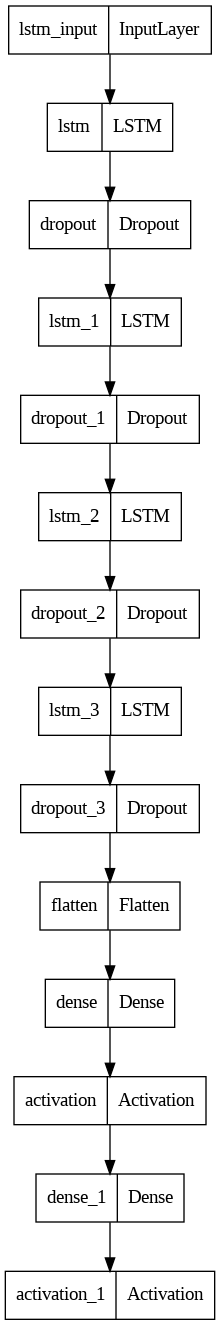

In [ ]:
ku.plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 256)          264192    
                                                                 
 dropout (Dropout)           (None, 100, 256)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 256)          525312    
                                                                 
 dropout_1 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 256)          525312    
                                                                 
 dropout_2 (Dropout)         (None, 100, 256)          0         
                                                                 
 lstm_3 (LSTM)               (None, 100, 256)          5

After we defined the model , we will define the needed callbacks.

### callback
A callback is a function that is called after every epoch

in our case we will call the checkpoint callback , what a checkpoint callback does is saving the weights of the model every time the model gets better.

In [ ]:
# Configure the checkpoint :
checkpoint_name = 'Weights-LSTM-improvement-{epoch:03d}-{loss:.5f}-bigger.hdf5'
checkpoint = ModelCheckpoint(checkpoint_name, monitor='loss', verbose = 1, save_best_only = True, mode ='min')
callbacks_list = [checkpoint]

## Training
A model can't do a thing if it did not train.



We can tweak `model_params` to get a better model

In [ ]:
# Fit the model : we have run the code for only two epochs, due to limited computational resources.
model_params = {'epochs':2,
                'batch_size':128,
                'callbacks':callbacks_list,
                'verbose':1,
                'validation_split':0.2,
                'validation_data':None,
                'shuffle': True,
                'initial_epoch':0,
                'steps_per_epoch':None,
                'validation_steps':None}

model.fit(X,
          y,
          epochs = model_params['epochs'],
           batch_size = model_params['batch_size'],
           callbacks= model_params['callbacks'],
           verbose = model_params['verbose'],
           validation_split = model_params['validation_split'],
           validation_data = model_params['validation_data'],
           shuffle = model_params['shuffle'],
           initial_epoch = model_params['initial_epoch'],
           steps_per_epoch = model_params['steps_per_epoch'],
           validation_steps = model_params['validation_steps'])


Epoch 1/2
1085/1085 [==============================] - ETA: 0s - loss: 3.4018
Epoch 1: loss improved from inf to 3.40179, saving model to Weights-LSTM-improvement-001-3.40179-bigger.hdf5
1085/1085 [==============================] - 3303s 3s/step - loss: 3.4018 - val_loss: 3.1300
Epoch 2/2


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1085/1085 [==============================] - ETA: 0s - loss: 3.0632
Epoch 2: loss improved from 3.40179 to 3.06318, saving model to Weights-LSTM-improvement-002-3.06318-bigger.hdf5
1085/1085 [==============================] - 3225s 3s/step - loss: 3.0632 - val_loss: 3.0496


We can see that some files have been downloaded ('Weights-LSTM-improvement-{epoch:03d}-{loss:.5f}-bigger.hdf5'), we can use such files to load the trained weights to be used in untrained models (i.e we don't have to train a model every time we want to use it)

The procedure to load the weights is mentioned below:



In [ ]:
 #Load weights file :
weights_file = '/content/Weights-LSTM-improvement-001-3.40179-bigger.hdf5' # weights file path
model.load_weights(weights_file)
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

Now , after we trained the model ,we can use it to generate fake  lyrics

## Generating lyrics
We first pick a random seed , then we will use it to generate lyrics character by character .

In [ ]:
# set a random seed :
start = np.random.randint(0, len(data_X)-1)
pattern = data_X[start]
print('Seed : ')
print("\"",''.join([int_chars[value] for value in pattern]), "\"\n")

# How many characters you want to generate
generated_characters = 300
generated_text = []

# Generate Charachters :
for i in range(generated_characters):
    x = np.reshape(pattern, ( 1, len(pattern), 1))
    x = x / float(n_vocab)
    prediction = model.predict(x,verbose = 0)
    index = np.argmax(prediction)
    result = int_chars[index]
    #seq_in = [int_chars[value] for value in pattern]
    sys.stdout.write(result)
    generated_text.append(result)
    pattern.append(index)
    pattern = pattern[1:len(pattern)]
print('\nGenerated Text:')
print("\"", generated_text_string, "\"\n")
print('\nDone')



Seed : 
" follow you follow you home, follow you follow you home
this slope is treacherous
and i-i-i like it
o "

                                                                                                                                                                                                                                                                                                            
Generated Text:
" bout the place where you first met me
in a getaway car, oh-oh-oh
no, they never get far, oh-oh-ahh
n                                                                                                                                                                                                                                                                                                             "


Done
